# Mask R-CNN - Inspect ScrANTon Trained Model

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import warnings
warnings.filterwarnings('ignore')

# Root directory of the project
ROOT_DIR = os.path.abspath(r"/home/simulation/Documents/Github/ScrANTonTracker/ScrANTonTrackerLAB/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from ants import ants

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = r"/home/simulation/Documents/TITANlogs/TRAINEDFULLANTS.h5" #TRAINEDFULLANTS.h5"  # TODO: update this path
MODEL_DIR = BALLON_WEIGHTS_PATH

Using TensorFlow backend.


## Configurations

In [2]:
config = ants.AntConfig()
ANT_DIR = os.path.join(ROOT_DIR, "data")

In [3]:
class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = .8

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [4]:
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Load validation dataset
dataset = ants.AntDataset()
dataset.load_ant(ANT_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
Images: 681
Classes: ['BG', 'Full Ant', 'Abdomen', 'Thorax', 'Head']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

W0818 13:17:52.617586 140106090931968 deprecation_wrapper.py:119] From /home/simulation/anaconda3/envs/ants/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 13:17:52.621681 140106090931968 deprecation_wrapper.py:119] From /home/simulation/anaconda3/envs/ants/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 13:17:52.625140 140106090931968 deprecation_wrapper.py:119] From /home/simulation/anaconda3/envs/ants/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 13:17:52.656015 140106090931968 deprecation_wrapper.py:119] From /home/simulation/anaconda3/envs/ants/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_n

## Load Model

In [8]:
weights_path = r"/home/simulation/Documents/TITANlogs/TRAINEDFULLANTS.h5" #TRAINEDFULLANTS.h5"
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/simulation/Documents/TITANlogs/TRAINEDFULLANTS.h5


## Run Detection

image ID: ScrANTonDataset.cjx2lowze1z9d0811xccra1p8 (589) None
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (4,)                  min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (4, 4)                min:  362.00000  max:  539.00000  int32
gt_mask                  shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  bool


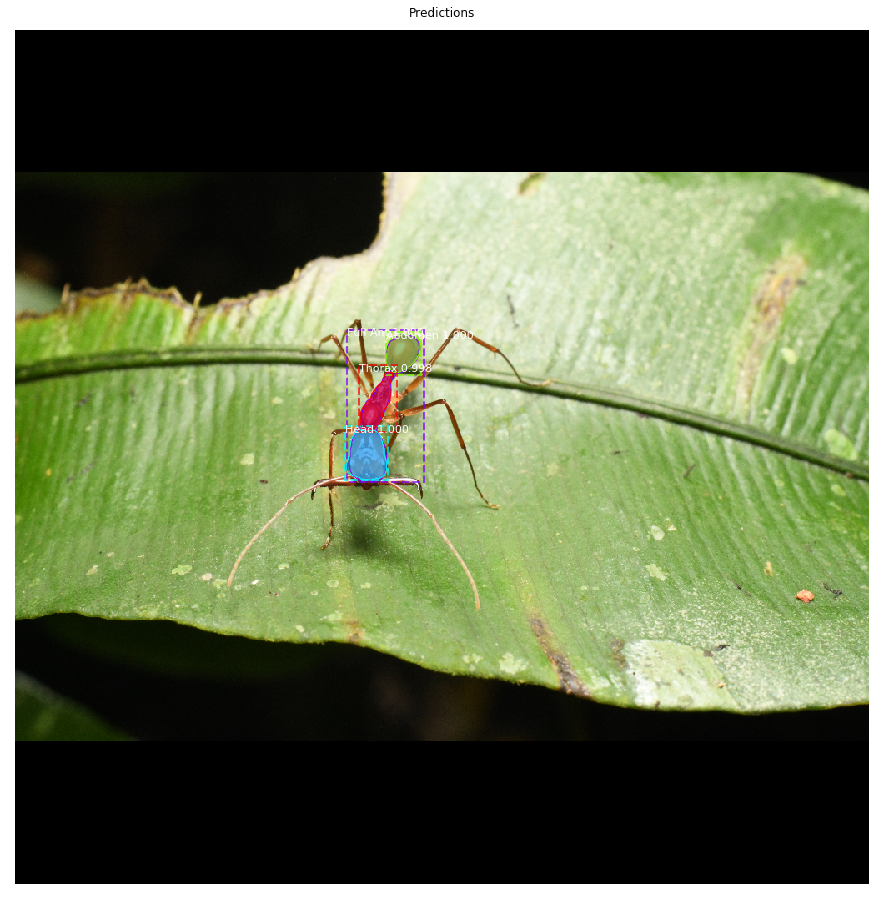

In [24]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)